In [362]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from colicoords import CellPlot, Cell, load, save, AutoIterCellPlot, iter_subplots, IterCellPlot, CellFit
from colicoords.preprocess import filter_binaries
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

In [3]:
def load_im():
    return np.load('binary.npy'), np.load('brightfield.npy'), np.load('storm.npy')


cell_list = load('temp_cells.hdf5')
binary, brightfield, storm = load_im()

<IPython.core.display.Javascript object>


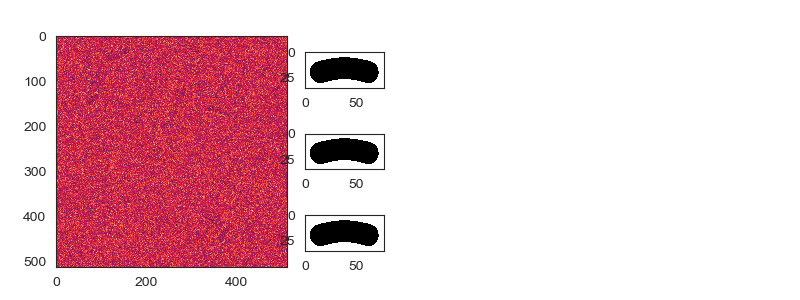

In [82]:
plt.figure(figsize=(8, 3))
gs1 = gridspec.GridSpec(3, 2, width_ratios=[1, 0.3])
gs1.update(left=0.05, right=0.48, wspace=0.01)
ax1 = plt.subplot(gs1[:, :-1])
ax1.imshow(im[0])

cp = CellPlot(cell_list[0])

ax2 = plt.subplot(gs1[0, -1])
cp.imshow("binary", ax=ax2)
ax3 = plt.subplot(gs1[1, -1])
cp.imshow("binary", ax=ax3)


ax4 = plt.subplot(gs1[2, -1])
cp.imshow("binary", ax=ax4)
plt.tight_layout()

In [89]:
data_dir = r'D:\Projects\CC_paper\figure_6_v3'
photons = [500, 1000, 10000]
conditions = ['binary', 'brightfield', 'storm_inner']

In [83]:
for ph in photons:
    im = np.load(os.path.join(data_dir, 'images', 'bf_noise_{}_photons.npy'.format(ph)))
    np.save(os.path.join(data_dir, 'plot_vars', 'bf_noise_{}_photons.npy'.format(ph)), im[0])

In [84]:
imgs = {ph: np.load(os.path.join(data_dir, 'plot_vars', 'bf_noise_{}_photons.npy'.format(ph))) for ph in photons}

In [281]:
gt_binary = np.load(os.path.join(data_dir, 'images', 'binary.npy'))

In [286]:
gt_f = filter_binaries(gt_binary)

In [295]:
del im

In [292]:
%whos

Variable          Type                       Data/Info
------------------------------------------------------
Cell              type                       <class 'colicoords.cell.Cell'>
CellPlot          type                       <class 'colicoords.plot.CellPlot'>
alpha             float                      0.75
ax                AxesSubplot                AxesSubplot(0.853641,0.11;0.126359x0.155951)
ax1               AxesSubplot                AxesSubplot(0.689375,0.699884;0.18579x0.265116)
ax2               AxesSubplot                AxesSubplot(0.889806,0.898998;0.090194x0.0660019)
ax3               AxesSubplot                AxesSubplot(0.889806,0.799441;0.090194x0.0660019)
ax4               AxesSubplot                AxesSubplot(0.889806,0.699884;0.090194x0.0660019)
axins             AxesHostAxes               AxesHostAxes(0.462899,0.442032;0.3875x0.385)
binary            ndarray                    5x512x512: 1310720 elems, type `float64`, 10485760 bytes (10.0 Mb)
bins          

In [289]:
np.sum([len(np.unique(fr)) - 1 for fr in gt_f])

7177

In [94]:
for ph in photons:
    for condition in conditions:
        print(ph, condition)
        m_cells = load(os.path.join(data_dir, 'cell_obj', 'm_cells_ph_{}_filtered_{}.hdf5'.format(ph, condition)))
        save(os.path.join(data_dir, 'plot_vars', 'cells_{}_{}_photons.hdf5'.format(condition, ph)), m_cells[:20])

500 binary
500 brightfield
500 storm_inner
1000 binary
1000 brightfield
1000 storm_inner
10000 binary
10000 brightfield
10000 storm_inner


In [ ]:
m_cells = load(os.path.join(data_dir, 'cell_obj', 'm_cells_ph_{}_filtered_{}.hdf5'.format(ph, condition)))

In [360]:
cell_dict

{500: {'binary': <colicoords.cell.CellList at 0x21bf69ee278>,
  'brightfield': <colicoords.cell.CellList at 0x21bf6a0bfd0>,
  'storm_inner': <colicoords.cell.CellList at 0x21bf6a28828>},
 1000: {'binary': <colicoords.cell.CellList at 0x21bf6a57588>,
  'brightfield': <colicoords.cell.CellList at 0x21bf6a74710>,
  'storm_inner': <colicoords.cell.CellList at 0x21bf6a94438>},
 10000: {'binary': <colicoords.cell.CellList at 0x21bf6ab1550>,
  'brightfield': <colicoords.cell.CellList at 0x21bf6add320>,
  'storm_inner': <colicoords.cell.CellList at 0x21bf6afbb38>}}

In [394]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [364]:
def cell_to_dict(cell):
    return {attr: getattr(cell.coords, attr) for attr in ['a0', 'a1', 'a2', 'r', 'xl', 'xr']}

In [430]:
from colicoords.fitting import CellMinimizeFunctionBase

class CustomFunc(CellMinimizeFunctionBase):
    """
    Image element objective function.

    Calling this object with coordinate system parameters returns a reconstructed image of the target data element.
    """
    #todo add additional parameters to init parameters
    def __call__(self, **parameters):
        print(parameters)
        r = parameters.pop('r', self.cell_obj.coords.r)
        r = r / self.cell_obj.coords.r

        self.cell_obj.coords.sub_par(parameters)
        #todo check and make sure that the r_dist isnt calculated to far out which can give some strange results

        stop = np.max(self.cell_obj.data.shape) / 2
        step = 0.5

        #todo some way to access these kwargs
        #todo scipy.fftsmth.convolve
        xp, fp = self.cell_obj.r_dist(stop, step, data_name=self.data_name, method='gauss')
        simulated = np.interp(r * self.cell_obj.coords.rc, xp, np.nan_to_num(fp))  # todo check nantonum cruciality

        return simulated

In [431]:
def get_obj_value(cell, data_name):
    d = cell_to_dict(cell)
    cf = CellImageFunction
    fit = CellFit(cell.copy(), data_name, cell_function=CustomFunc)
    return fit.fit.objective(**d)

In [432]:
cb = cell_dict[10000]['brightfield'][0].copy()
cb.coords.r = 200
get_obj_value(cb, 'brightfield')

cell func <class '__main__.CustomFunc'>
fumk klass <class '__main__.CustomFunc'>
cellf,  <__main__.CustomFunc object at 0x0000021B94F65898>
{'a0': 8.581879450273673, 'a1': 0.6731007571238854, 'a2': -0.008624771196872175, 'r': 200, 'xl': 17.926936832366334, 'xr': 59.407968340171024}


34064112.54451211

In [433]:
cs = cell_dict[10000]['storm_inner'][0].copy()
get_obj_value(cs, 'brightfield')

cell func <class '__main__.CustomFunc'>
fumk klass <class '__main__.CustomFunc'>
cellf,  <__main__.CustomFunc object at 0x0000021B8A83DA58>
{'a0': 9.233346524691315, 'a1': 0.6290679848401511, 'a2': -0.007872421890809611, 'r': 5.013958112205766, 'xl': 18.120188596465486, 'xr': 61.1161161864686}


31248929.79879197

<IPython.core.display.Javascript object>


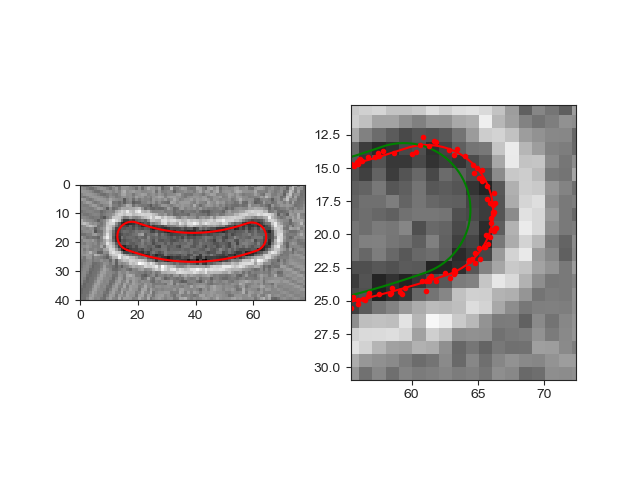

In [381]:
fig, axes = plt.subplots(1, 2)


cp = CellPlot(cb)
cp.imshow('brightfield', ax=axes[0])
cp.plot_outline(ax=axes[0])

cp = CellPlot(cs)
cp.imshow('brightfield', ax=axes[1])
cp.plot_outline(ax=axes[1])

cb.coords.r = cs.coords.r
cp = CellPlot(cb)
cp.plot_outline(ax=axes[1], color='g')
cp.plot_storm()

In [110]:
import matplotlib.colors as mcolors

#https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
mcm = make_colormap(
    [ c('black'), c('magenta')])
ccm = make_colormap(
    [c('black'), c('cyan')])

In [114]:
def prune(arr):
    arr = arr.flatten()
    arr[np.isinf(arr)] = 10
    return arr[~np.isnan(arr)]

In [97]:
cell_dict = {}
for ph in photons:
    cell_dict[ph] = {}
    for condition in conditions:
        cell_dict[ph][condition] = load(os.path.join(data_dir, 'plot_vars', 'cells_{}_{}_photons.hdf5'.format(condition, ph)))

<IPython.core.display.Javascript object>


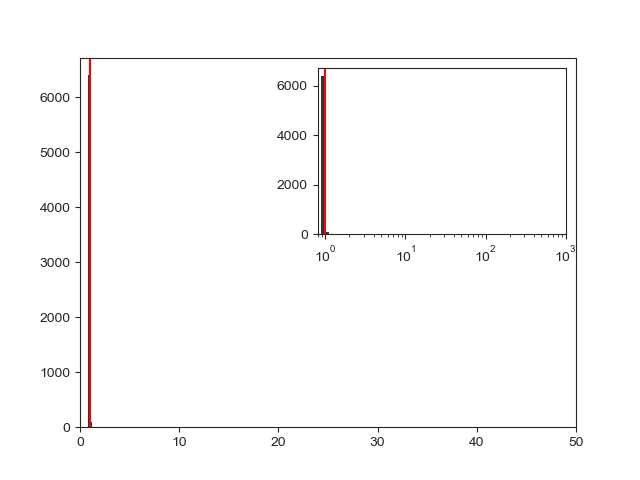

In [154]:
import seaborn as sns
sns.set_style("ticks")
fig, ax = plt.subplots()
make_obj_hist(ax, v)

In [191]:
linewidth

0.5

<IPython.core.display.Javascript object>


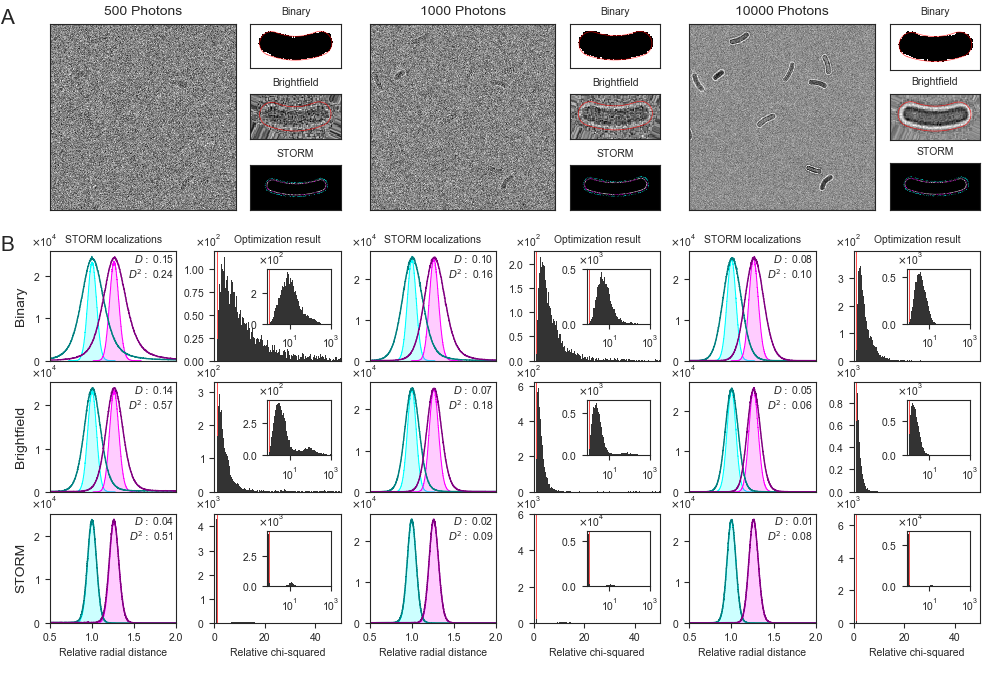

In [484]:
labelsize=7.5
upscale = 10  # STORM render resolution
step = 1 # fraction of points plotted in histogram
linewidth=0.5

colors = ['cyan', 'magenta', (0, 0.5, 0.5), (0.5, 0, 0.5)]
def make_r_hist(ax, r1, r2, r3, r4, step=1):
    h = ax.hist(r1[::step], bins='fd', linewidth=0.75, histtype='step', color=colors[0])
    h = ax.hist(r1[::step], bins='fd', linewidth=0, alpha=0.2, color=colors[0])

    h = ax.hist(r2[::step], bins='fd', linewidth=0.75, linestyle='-', histtype='step', color=colors[1])
    h = ax.hist(r2[::step], bins='fd', linewidth=0, linestyle='-', alpha=0.2, color=colors[1])

    h = ax.hist(r3[::step], bins='fd', linewidth=1, histtype='step', color=colors[2])
    
    h = ax.hist(r4[::step], bins='fd', linewidth=1, histtype='step', color=colors[3])
    
    ax.set_xlim(0.5, 2)

def make_obj_hist(ax, values, step=1):
    binwidth = 0.2
    bins = np.arange(0, 50 + binwidth, binwidth)
    bins_log = 10**np.arange(-1, 5.5, 0.05)

    h = ax.hist(values[::step], bins=bins, color='#333333', linewidth=0)
    ax.axvline(1, color='r', linewidth=linewidth, zorder=-1)
    ax.set_xlim(0, 50)
    
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     width, height = bbox.width, bbox.height
    axins = inset_axes(ax, width='100%', height='100%', bbox_to_anchor=(0.475,0.4,0.5,0.5), bbox_transform=ax.transAxes, loc=1)
    axins.hist(values[::step], bins=bins_log, color='#333333', linewidth=0)
    axins.set_xscale('log')
    axins.axvline(1, color='r', linewidth=linewidth, zorder=-1)
    axins.tick_params(direction='out', labelsize=labelsize)
    axins.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
    axins.set_xlim(8e-1, 1000)
    axins.yaxis.offsetText.set_fontsize(labelsize)
    axins.yaxis.offsetText.set_position((-0.15, 0.75))


fig = plt.figure(figsize=(10, 17.8 /2.54), constrained_layout=True)
outer_grid = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, height_ratios=[0.5, 1])
outer_grid.update(left=0.05, right=0.98, top=0.965)
for i, ph in enumerate(photons):
    inner_grid = gridspec.GridSpecFromSubplotSpec(3, 2, width_ratios=[1, 0.45],
            subplot_spec=outer_grid[0, i], wspace=0.0, hspace=0.)

    ax1 = plt.subplot(inner_grid[:, :-1])
    ax1.imshow(imgs[ph], cmap='gray')
    ax1.set_anchor('W')
    ax1.set_title('{} Photons'.format(ph), fontsize=10)
    
    if ph == 500:
        p0 = ax1.get_position()
        fig.text(0.0, p0.y0 + p0.height, 'A', fontsize=15)
   
    ci = 0
    linewidth=0.5
    alpha =0.75
    
    ax2 = plt.subplot(inner_grid[0, -1])
    ax2.set_anchor('NE')
    cp = CellPlot(cell_dict[ph]['binary'][ci])
    cp.imshow("binary", ax=ax2)
    cp.plot_outline(ax=ax2, linewidth=linewidth, alpha=alpha)
    ax2.set_title('Binary', fontsize=labelsize)
    
    ax3 = plt.subplot(inner_grid[1, -1])
    ax3.set_anchor('E')
    cp = CellPlot(cell_dict[ph]['brightfield'][ci])
    cp.imshow("brightfield", ax=ax3)
    cp.plot_outline(ax=ax3, linewidth=linewidth, alpha=alpha)
    ax3.set_title('Brightfield', fontsize=labelsize)

    ax4 = plt.subplot(inner_grid[2, -1])
    ax4.set_anchor('SE')
    cp = CellPlot(cell_dict[ph]['storm_inner'][ci])     
    cp.imshow(np.zeros(cp.cell_obj.data.shape), cmap='gray', zorder=-2)  # Black background
    cp.plot_storm(data_name='storm_inner', upscale=upscale, method='gauss', alpha_cutoff=0.25, cmap=mcm)
    cp.plot_storm(data_name='storm_outer', upscale=upscale, method='gauss', alpha_cutoff=0.25, cmap=ccm)
    cp.plot_outline(ax=ax4, linewidth=linewidth, zorder=-1, color=[1,1,1])
    ax4.set_title('STORM', fontsize=labelsize)
    plt.tight_layout()
    #plt.subplots_adjust(left=0)
    
    plt.subplots_adjust(left=0, right=1, wspace=0)

    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xticks([])
        ax.set_yticks([])
    
for i, ph  in enumerate(photons):
    inner_grid = gridspec.GridSpecFromSubplotSpec(3, 2,
        subplot_spec=outer_grid[1, i], wspace=0.3)
    
    for j, cond in enumerate(conditions):
        if 1:#cond == 'binary' and ph == 500:
            # Create r histogram plot
            r_m_inner = prune(np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond))))
            r_m_outer = prune(np.load(os.path.join(data_dir, 'r_values', 'r_outer_m_ph_{}_{}.npy'.format(ph, cond))))
            r_gt_inner = prune(np.load(os.path.join(data_dir, 'r_values', 'r_inner_gt_ph_{}_{}.npy'.format(ph, cond))))
            r_gt_outer = prune(np.load(os.path.join(data_dir, 'r_values', 'r_outer_gt_ph_{}_{}.npy'.format(ph, cond))))
            
            dpts_inner = len(r_m_inner)

            D = np.mean(np.abs(r_m_inner - r_gt_inner))
            RMSD = np.sqrt(np.mean((r_m_inner - r_gt_inner)**2))
            
            gs = inner_grid[j, 0]
            ax = plt.subplot(gs)
            make_r_hist(ax, r_gt_inner, r_gt_outer, r_m_inner, r_m_outer, step=step)
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
            ax.yaxis.offsetText.set_fontsize(labelsize)
            ax.yaxis.offsetText.set_position((-0.15, 0.95))
   
            #ax.text(0.6, 0.8, '$D, RMSD = $\n${0:.2f}$\n${1:.2f}$'.format(D, RMSD), transform=ax.transAxes, fontsize=labelsize)
            ax.text(0.98, 0.75, '$D:$ {0:.2f}\n$D^2:$ {1:.2f}'.format(D, RMSD), transform=ax.transAxes, fontsize=labelsize,
                   multialignment='right', ha='right')

#             ax.text(0.7, 0.8, '$D = {0:.2f} $'.format(D), transform=ax.transAxes, fontsize=labelsize)
#             ax.text(0.7, 0.7, '$RMSD = {0:.2f} $'.format(RMSD), transform=ax.transAxes, fontsize=labelsize)

            if ph == 500:
                labels = ['Binary', 'Brightfield', 'STORM']
                ax.set_ylabel(labels[j])
                if j == 0:
                    p0 = ax.get_position()
                    fig.text(0.0, p0.y0 + p0.height, 'B', fontsize=15)
            if j == 0:
                ax.set_title('STORM localizations', fontsize=labelsize)
            if j < 2:
                ax.set_xticks([])
            else:
                ax.set_xlabel('Relative radial distance', fontsize=labelsize)
            
            ax.tick_params(labelsize=labelsize)

            # Create minimize result histogram
            gs = inner_grid[j, 1]
            ax = plt.subplot(gs)

            r_raw = np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond)))
            dpts = np.sum(~np.isnan(r_raw), axis=1)

            obj_vals = np.loadtxt(os.path.join(data_dir, 'obj_values_new', 'obj_vals_storm_ph_{}_{}.txt'.format(ph, cond)))
            obj_vals /= dpts[:, np.newaxis]
            
            v = obj_vals[:, 0] / obj_vals[:, 1]

            make_obj_hist(ax, v, step=1)
            
            if j == 0:
                ax.set_title('Optimization result', fontsize=labelsize)              
            if j < 2:
                ax.set_xticks([])
            else:
                ax.set_xlabel('Relative chi-squared', fontsize=labelsize)
                
            ax.tick_params(labelsize=labelsize)
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
            ax.yaxis.offsetText.set_fontsize(labelsize)
            ax.yaxis.offsetText.set_position((-0.15, 0.95))
            
#     for gs in inner_grid:
#         ax = plt.subplot(gs)
#         ax.hist(np.random.rand(100))
    
#     plt.tight_layout()

    
plt.savefig('test.png', dpi=600)
plt.savefig('test.pdf', dpi=1000)

In [452]:
ph = 10000
for cond in ['binary', 'brightfield', 'storm_inner']:
    r_m_inner = prune(np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond))))
    r_m_outer = prune(np.load(os.path.join(data_dir, 'r_values', 'r_outer_m_ph_{}_{}.npy'.format(ph, cond))))
    r_gt_inner = prune(np.load(os.path.join(data_dir, 'r_values', 'r_inner_gt_ph_{}_{}.npy'.format(ph, cond))))
    r_gt_outer = prune(np.load(os.path.join(data_dir, 'r_values', 'r_outer_gt_ph_{}_{}.npy'.format(ph, cond))))
    
    print(cond)
    print(np.mean(np.abs(r_m_inner - r_gt_inner)) * 100)
    print(np.sqrt(np.mean((r_m_inner - r_gt_inner)**2)) * 100)

binary
7.789209973285524
9.886898362398819
brightfield
4.619561093825276
6.0700673183437575
storm_inner
1.219057841644443
7.821204404565258


In [446]:
ph = 10000
for cond in ['binary', 'brightfield', 'storm_inner']:
    r_m_inner = prune(np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond))))
    r_m_outer = prune(np.load(os.path.join(data_dir, 'r_values', 'r_outer_m_ph_{}_{}.npy'.format(ph, cond))))
    r_gt_inner = prune(np.load(os.path.join(data_dir, 'r_values', 'r_inner_gt_ph_{}_{}.npy'.format(ph, cond))))
    r_gt_outer = prune(np.load(os.path.join(data_dir, 'r_values', 'r_outer_gt_ph_{}_{}.npy'.format(ph, cond))))
    
    print(cond)
    print(np.mean(np.abs(r_m_inner - r_gt_inner)) * 100)

binary
7.789209973285524
brightfield
4.619561093825276
storm_inner
1.219057841644443


In [437]:
r_gt_inner.mean()

0.9999557196731499

In [441]:
np.mean((r_m_inner - r_gt_inner)**2)

0.0036845717249224977

In [444]:
np.mean(np.abs(r_m_inner - r_gt_inner))

0.012190578416444432

In [236]:
outer_grid.annotate()

AttributeError: 'GridSpec' object has no attribute 'annotate'

In [359]:
m_cells

<IPython.core.display.Javascript object>


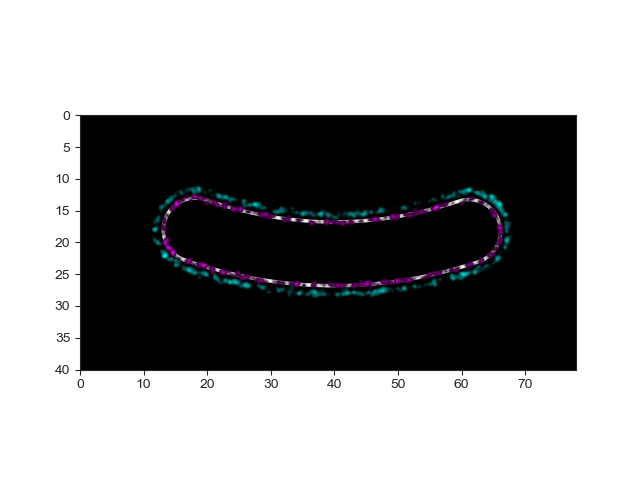

In [271]:
plt.figure()

cp = CellPlot(cell_dict[ph]['storm_inner'][ci])    
cp.imshow(np.zeros(cp.cell_obj.data.shape), cmap='gray', zorder=-2)  # Black background
cp.plot_storm(data_name='storm_inner', upscale=20, method='gauss', alpha_cutoff=0.25, cmap=mcm)
cp.plot_storm(data_name='storm_outer', upscale=20, method='gauss', alpha_cutoff=0.25, cmap=ccm)
cp.plot_outline(ax=plt.gca(), linewidth=2.5, alpha=1, color=[1, 1, 1], zorder=-1)


<IPython.core.display.Javascript object>


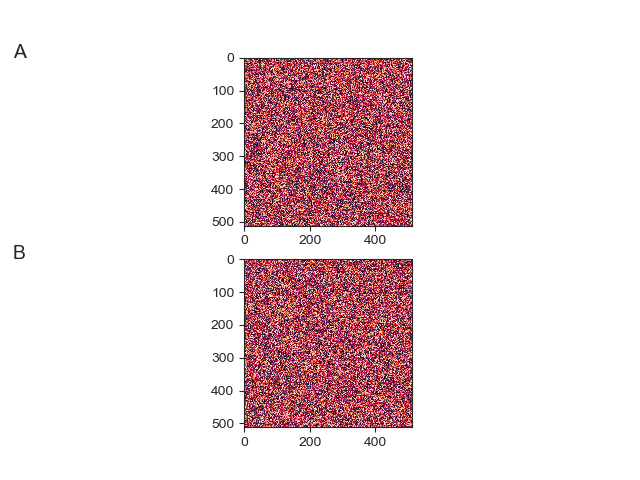

Text(0.02, 0.46, 'B')

In [252]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(np.random.rand(512, 512))
ax[1].imshow(np.random.rand(512, 512))

p0 = ax[0].get_position()
p1 = ax[1].get_position()

fig.text(0.02, p0.y0 + p0.height, 'A', fontsize=14)
fig.text(0.02, p1.y0 + p1.height, 'B', fontsize=14)


In [240]:
p0 = ax[0].get_position()

In [241]:
p0.x0

0.38125000000000003

In [246]:
p0

Bbox([[0.38125000000000003, 0.53], [0.64375, 0.88]])

In [249]:
p0.y0, p0.height

(0.53, 0.35)

In [250]:
p0.bounds

(0.38125000000000003, 0.53, 0.2625, 0.35)

In [311]:
lens.mean()

499.13576003749415

In [314]:
obj_vals /= lens[:, np.newaxis]

In [323]:
for ph in [10000, 1000, 500]:
    for cond in ['binary', 'brightfield', 'storm_inner']:
        r_m_inner = prune(np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond))))
        r_raw = np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond)))

        lens = np.sum(~np.isnan(r_raw), axis=1)

        obj_vals = np.loadtxt(os.path.join(data_dir, 'obj_values_new', 'obj_vals_storm_ph_{}_{}.txt'.format(ph, cond)))
        obj_vals /= lens[:, np.newaxis]
        v = obj_vals[:, 0] / obj_vals[:, 1]
        print(ph, cond, v.mean(), np.median(v), np.std(v))


10000 binary 4.480842055659154 3.642808069767177 2.873060137316437
10000 brightfield 2.3059152401991443 1.9190908371849789 2.1777434265895637
10000 storm_inner 3.2572534645270417 0.9926070749328645 57.423449760297444
1000 binary 9.806672083327683 5.389316323621021 25.87540581287231
1000 brightfield 11.684404068481722 2.5417874387548665 106.37464711318462
1000 storm_inner 3.6970781396818895 0.9932366234108407 42.45479854857908
500 binary 21.400698760946486 9.449751040428641 41.24509704043239
500 brightfield 119.04488994757936 3.8922413938903304 4244.3691802718995
500 storm_inner inf 0.9950444601904874 nan


<IPython.core.display.Javascript object>


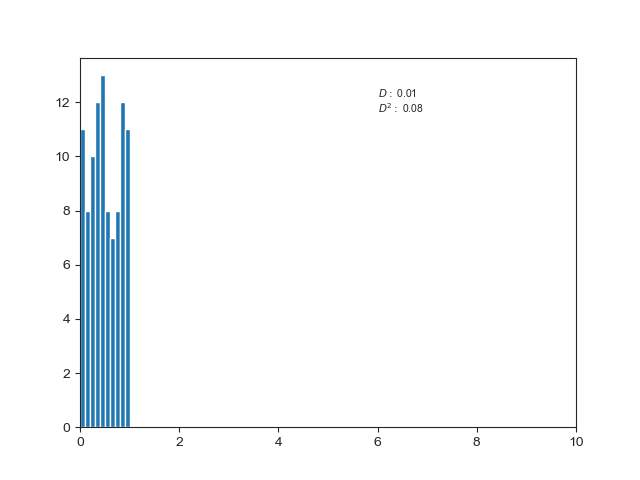

Text(0.6, 0.85, '$D:$ 0.01\n$D^2:$ 0.08')

In [476]:
fig, axes = plt.subplots()
axes.hist(np.random.rand(100))
axes.set_xlim(0, 10)
s = 0.12434524
axes.text(0.6, 0.85, '$D:$ {0:.2f}\n$D^2:$ {1:.2f}'.format(D, RMSD), transform=axes.transAxes, fontsize=labelsize)

In [356]:
for ph in [10000, 1000, 500]:
    for cond in ['storm_inner']:
        r_m_inner = prune(np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond))))
        r_raw = np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond)))

        lens = np.sum(~np.isnan(r_raw), axis=1)

        obj_vals = np.loadtxt(os.path.join(data_dir, 'obj_values_new', 'obj_vals_storm_ph_{}_{}.txt'.format(ph, cond)))
        obj_vals /= lens[:, np.newaxis]
        v = obj_vals[:, 0] / obj_vals[:, 1]
        print(ph, cond, v.mean(), np.median(v), np.std(v))
        print(np.sum(v > 20))

10000 storm_inner 3.2572534645270417 0.9926070749328645 57.423449760297444
48
1000 storm_inner 3.6970781396818895 0.9932366234108407 42.45479854857908
43
500 storm_inner inf 0.9950444601904874 nan
76


(7177, 720)
(7177,)
3581511
3.2572534645270417
0.9926070749328645


<IPython.core.display.Javascript object>


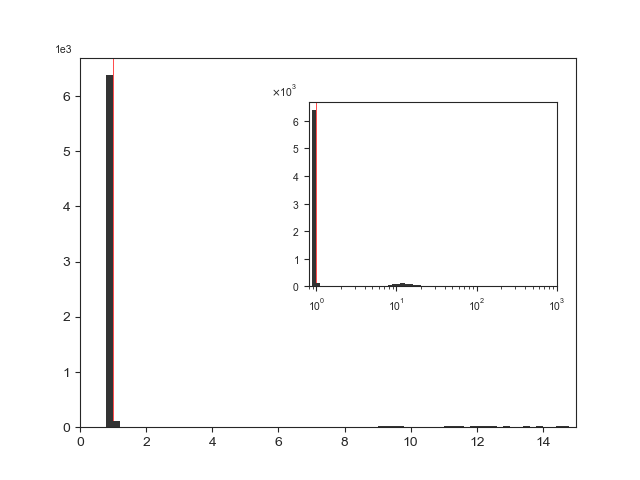

(0, 15)

In [353]:
ph = 10000
cond = 'storm_inner'

r_m_inner = prune(np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond))))
r_raw = np.load(os.path.join(data_dir, 'r_values', 'r_inner_m_ph_{}_{}.npy'.format(ph, cond)))
print(r_raw.shape           )
lens = np.sum(~np.isnan(r_raw), axis=1)
print(lens.shape)
dpts_inner = len(r_m_inner)
print(dpts_inner)


obj_vals = np.loadtxt(os.path.join(data_dir, 'obj_values_new', 'obj_vals_storm_ph_{}_{}.txt'.format(ph, cond)))
#obj_vals /= lens[:, np.newaxis]
v = obj_vals[:, 0] / obj_vals[:, 1]
print(v.mean())
print(np.median(v))
fig, ax = plt.subplots()
make_obj_hist(ax, v)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax.yaxis.offsetText.set_fontsize(labelsize)
ax.yaxis.offsetText.set_position((-0.05, 1))
ax.set_xlim(0, 15)

In [337]:
%load_ext autoreload

In [349]:
np.sum(v>50)

10

In [350]:
ph = 10000
condition = 'storm_inner'
m_names = np.genfromtxt(os.path.join(data_dir, 'matched_names', 'm_cells_ph_{}_match_filter.txt'.format(ph)), dtype=str)    

m_index = np.searchsorted(m_cells.name, m_names)

            # sorting CellList object by indexing; no copying is done.
m_sorted = m_cells[m_index]


<IPython.core.display.Javascript object>


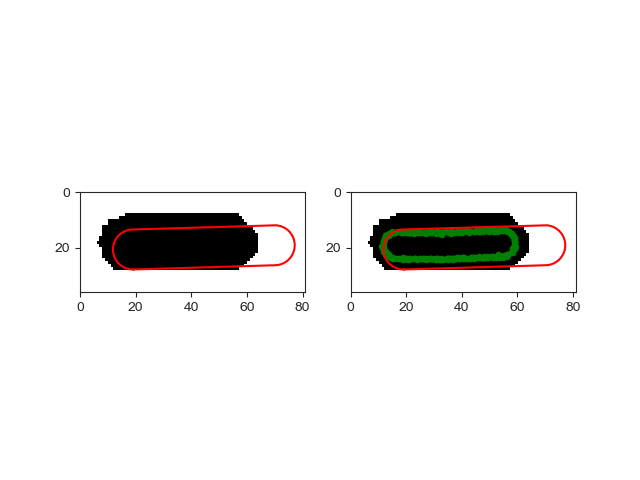

In [351]:
fig, axes = iter_subplots(1, 2)
icp = IterCellPlot(m_sorted[v > 50])
icp.imshow('binary', ax=axes[0])
icp.plot_outline(ax=axes[0])
icp.imshow('binary', ax=axes[1])
icp.plot_storm(method='plot', ax=axes[1], color='g')
icp.plot_outline(ax=axes[1])
fig.display()

In [333]:
len(m_cells)

7177

In [332]:
%whos

Variable          Type                       Data/Info
------------------------------------------------------
Cell              type                       <class 'colicoords.cell.Cell'>
CellPlot          type                       <class 'colicoords.plot.CellPlot'>
alpha             float                      0.75
ax                AxesSubplot                AxesSubplot(0.125,0.11;0.775x0.77)
ax1               AxesSubplot                AxesSubplot(0.689375,0.699884;0.18579x0.265116)
ax2               AxesSubplot                AxesSubplot(0.889806,0.898998;0.090194x0.0660019)
ax3               AxesSubplot                AxesSubplot(0.889806,0.799441;0.090194x0.0660019)
ax4               AxesSubplot                AxesSubplot(0.889806,0.699884;0.090194x0.0660019)
axins             AxesHostAxes               AxesHostAxes(0.462899,0.442032;0.3875x0.385)
binary            ndarray                    5x512x512: 1310720 elems, type `float64`, 10485760 bytes (10.0 Mb)
bins              ndarra

21.433355097274077


<IPython.core.display.Javascript object>


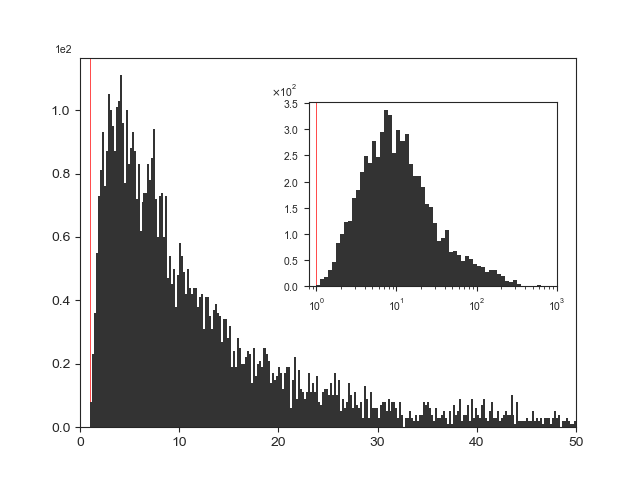

In [296]:
ph = 500
cond = 'binary'a

obj_vals = np.loadtxt(os.path.join(data_dir, 'obj_values', 'obj_vals_storm_ph_{}_{}.txt'.format(ph, cond)))
v = obj_vals[:, 0] / obj_vals[:, 1]
print(v.mean())

fig, ax = plt.subplots()
make_obj_hist(ax, v)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax.yaxis.offsetText.set_fontsize(labelsize)
ax.yaxis.offsetText.set_position((-0.05, 1))

In [298]:
v[v>500]

array([602.83733352, 574.14775537, 794.78744404, 713.63147217,
       979.84682165])

<IPython.core.display.Javascript object>


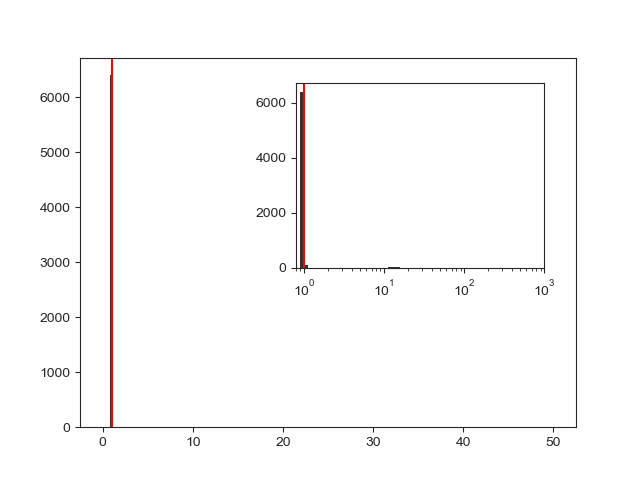

(0.8, 1000)

In [208]:
binwidth = 0.2
bins=np.arange(0, 50 + binwidth, binwidth)
bins_l = 10**np.arange(-1, 5.5, 0.05)

plt.figure()
h = plt.hist(v, bins=bins, color='#333333', linewidth=0)
ax = plt.gca()
axins = inset_axes(ax, width='100%', height='100%', bbox_to_anchor=(0.45,0.45,0.5,0.5), bbox_transform=ax.transAxes, loc=1)
#h = plt.hist(v1, bins=bins, alpha=0.5)
#h = plt.hist(v2, bins=bins, alpha=0.5)
axins.hist(v, bins=bins_l, color='#333333', linewidth=0)
axins.set_xscale('log')
axins.axvline(1, color='r')

#plt.xscale('log')
ax.axvline(1, color='r')
plt.xlim(8e-1, 1000)
#plt.savefig('10k_storm.png')

<IPython.core.display.Javascript object>


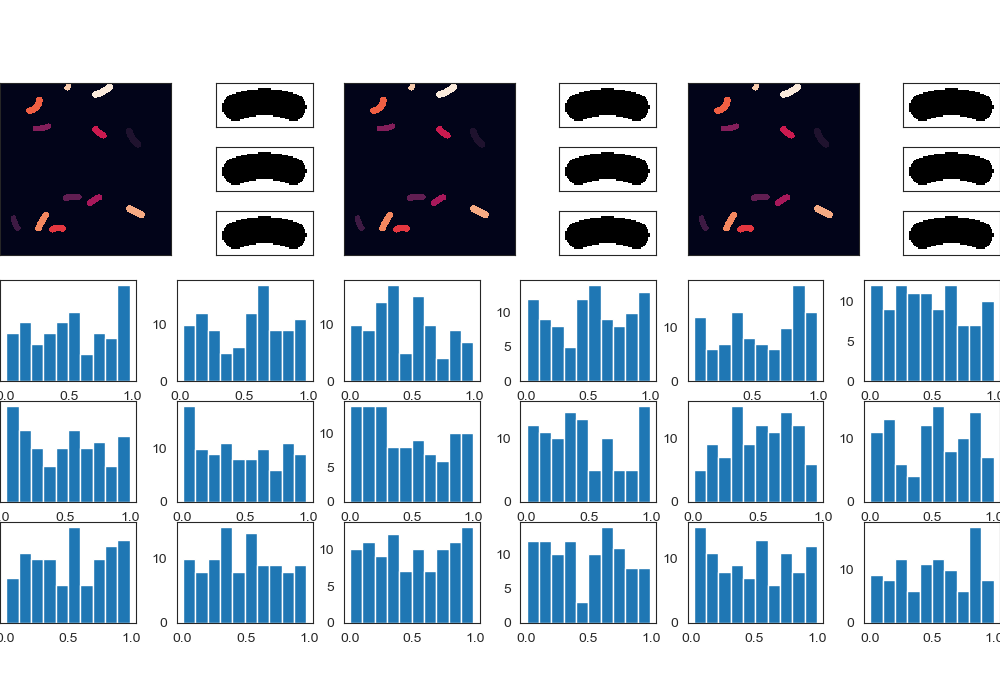

In [76]:
fig = plt.figure(figsize=(10, 17.8 /2.54))
outer_grid = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.1, height_ratios=[0.5, 1])

for i in range(3):
    inner_grid = gridspec.GridSpecFromSubplotSpec(3, 2, width_ratios=[1, 0.45],
            subplot_spec=outer_grid[0, i], wspace=0.0, hspace=0.)

    ax1 = plt.subplot(inner_grid[:, :-1])
    ax1.imshow(binary[0])
    ax1.set_anchor('W')
    cp = CellPlot(cell_list[0])

    ax2 = plt.subplot(inner_grid[0, -1])
    ax2.set_anchor('NE')
    cp.imshow("binary", ax=ax2)
    ax3 = plt.subplot(inner_grid[1, -1])
    ax3.set_anchor('E')
    cp.imshow("binary", ax=ax3)


    ax4 = plt.subplot(inner_grid[2, -1])
    ax4.set_anchor('SE')
    cp.imshow("binary", ax=ax4)
    plt.tight_layout()
    #plt.subplots_adjust(left=0)
    
    plt.subplots_adjust(left=0, right=1, wspace=0)

    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xticks([])
        ax.set_yticks([])
    
for i in range(3):
    inner_grid = gridspec.GridSpecFromSubplotSpec(3, 2,
        subplot_spec=outer_grid[1, i], wspace=0.3)
    
    for gs in inner_grid:
        ax = plt.subplot(gs)
        ax.hist(np.random.rand(100))
    
    plt.tight_layout()



<IPython.core.display.Javascript object>


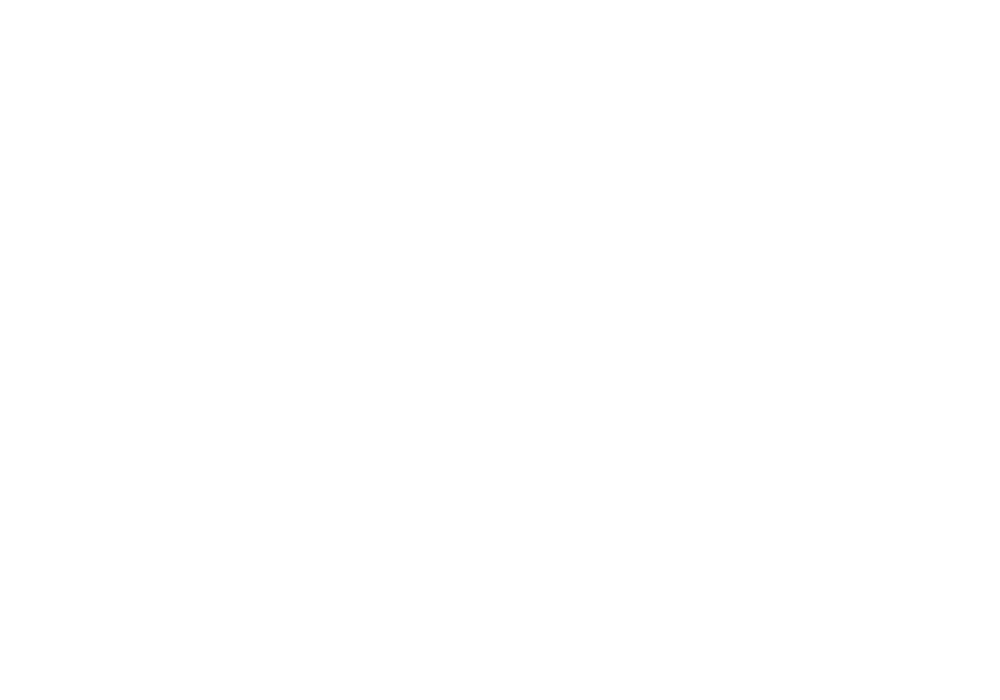

In [6]:


fig = plt.figure(figsize=(10, 17.8 /2.54))
